In [11]:
%matplotlib inline
from utils import *
from plotting import *
from models import *
import os
import pickle
import pandas as pd
from matplotlib.ticker import LogLocator, NullFormatter

## Power laws

In [36]:
tasks = ['doubleTmaze', 'cylinder', 'permanence', 'thorndike']
model_types = ['sparse-AE', 'AE']

In [58]:
## For models

#results = {}
for model_type in model_types:
    results[model_type] = {}
    for task in tasks:
        print(model_type, task)
        
        # Load dataset and model
        dataset, position = load_dataset(directory='datasets/' + task, task=task)
        model = Conv_AE(n_hidden=1000).to('cuda')
        model.load_state_dict(torch.load('saved_models/main_{}_{}_1000hidden.pth'.format(task, model_type)))

        # Get latent embeddings
        embeddings = get_latent_vectors(dataset, model)
        embeddings[embeddings < 1e-5] = 0
        
        # Get power-law results
        m, b, variances = get_powerlaw_exp(embeddings, start_fit=10, cutoff_fit=100)
        
        # Store the results in the dictionary
        results[model_type][task] = {
            'm': m,
            'b': b,
            'variances': variances
        }

sparse-AE doubleTmaze
sparse-AE cylinder
sparse-AE permanence
sparse-AE thorndike
AE doubleTmaze
AE cylinder
AE permanence
AE thorndike


In [14]:
## For datasets

results['dataset'] = {}
for task in tasks:
    print(task)

    # Load dataset and model
    dataset, position = load_dataset(directory='datasets/' + task, task=task)
    
    dataset_reshaped = dataset.reshape((dataset.shape[0], int(dataset.shape[1]*dataset.shape[2]*dataset.shape[3])))

    # Get power-law results
    m, b, variances = get_powerlaw_exp(dataset_reshaped, start_fit=0, cutoff_fit=2000)

    # Store the results in the dictionary
    results['dataset'][task] = {
        'm': m,
        'b': b,
        'variances': variances
    }

doubleTmaze
cylinder
permanence
thorndike


In [73]:
# Ensure the directory exists
os.makedirs('results', exist_ok=True)

# Save the results dictionary to a file in the 'results' folder
file_path = os.path.join('results', 'all_powerlaws.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# Load and print the results to check
file_path = os.path.join('results', 'all_powerlaws.pkl')
with open(file_path, 'rb') as f:
    results = pickle.load(f)

#### Plot

In [105]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, NullFormatter

# Assuming `results` dictionary is already populated from the previous code.

plt.figure(figsize=(16, 10), dpi=600)

# Custom style settings
colors = {'sparse-AE': '#4E79A7', 'AE': '#F28E2B', 'dataset': '#999999'}
alpha_value = 0.8
line_width = 3
line_style = '--'
edge_color = 'black'
edge_line_width = 1.5
text_color = 'gray'
font_size_labels = 18
font_size_text = 18
y_label = 'Variance'

row_labels = ["Sparse", "Dense", "Images"]

# Add row labels for Sparse, Dense, Images
for i, label in enumerate(row_labels):
    plt.figtext(-0.04, 0.815 - i * 0.305, label, fontsize=20, fontweight='bold', ha='center', va='center', rotation='horizontal')

# Plotting the data
for i, model_type in enumerate(model_types):
    for j, task in enumerate(tasks):
        variances = results[model_type][task]['variances']
        m = results[model_type][task]['m']
        b = results[model_type][task]['b']
        
        ax = plt.subplot(len(model_types) + 1, len(tasks) + 1, i * (len(tasks) + 1) + j + 1)
        if j == 0:
            plt.ylabel(y_label, fontsize=font_size_labels)
        
        # Apply y-limits and mask data outside the limits
        y_lim = [1e-5, 1e-0]
        variances = np.clip(variances, y_lim[0], y_lim[1])
        
        plt.plot(np.arange(1, len(variances) + 1), variances, color=colors[model_type], linewidth=line_width, alpha=alpha_value)
        
        x_fit = np.linspace(1, len(variances) + 1, 100)
        y_fit = np.exp(b) * x_fit ** m
        y_fit = np.clip(y_fit, y_lim[0], y_lim[1])
        plt.plot(x_fit, y_fit, linestyle=line_style, color=edge_color, linewidth=edge_line_width)
        
        plt.text(x=50, y=4e-3, s='$\\alpha$ = ' + str(np.around(-m, 2)), color=colors[model_type], fontsize=font_size_text)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim(y_lim)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax.xaxis.set_minor_formatter(NullFormatter())
        sb.despine()
        plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')

# For datasets (images row)
for j, task in enumerate(tasks):
    variances = results['dataset'][task]['variances']
    m = results['dataset'][task]['m']
    b = results['dataset'][task]['b']

    ax = plt.subplot(len(model_types) + 1, len(tasks) + 1, len(model_types) * (len(tasks) + 1) + j + 1)
    if j == 0:
        plt.ylabel(y_label, fontsize=font_size_labels)
    
    # Apply y-limits and mask data outside the limits
    y_lim = [1e-7, 1e-0]
    variances = np.clip(variances, y_lim[0], y_lim[1])
    
    plt.plot(np.arange(1, len(variances) + 1), variances, color=colors['dataset'], linewidth=line_width, alpha=alpha_value)

    x_fit = np.linspace(1, len(variances) + 1, 100)
    y_fit = np.exp(b) * x_fit ** m
    y_fit = np.clip(y_fit, y_lim[0], y_lim[1])
    plt.plot(x_fit, y_fit, linestyle=line_style, color=edge_color, linewidth=edge_line_width)

    plt.text(x=50, y=4e-3, s='$\\alpha$ = ' + str(np.around(-m, 2)), color=colors['dataset'], fontsize=font_size_text)
    plt.xlabel('PC dim.', fontsize=font_size_labels)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(y_lim)
    plt.yticks(fontsize=15)
    ax.set_xticks([1, 10, 100, 1000, 10000])  # Set specific xticks
    ax.set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'], fontsize=15)
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
    ax.xaxis.set_minor_formatter(NullFormatter())
    sb.despine()
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')

# For averaged results with standard deviations
for i, model_type in enumerate(model_types + ['dataset']):
    
    all_variances = [results[model_type][task]['variances'] for task in tasks]
    avg_variances = np.mean(all_variances, axis=0)
    std_devs = np.std(all_variances, axis=0)

    ax = plt.subplot(len(model_types) + 1, len(tasks) + 1, (i + 1) * (len(tasks) + 1))
    
    # Apply y-limits and mask data outside the limits
    y_lim = [1e-7, 1e-0] if i == 2 else [1e-5, 1e-0]
    avg_variances = np.clip(avg_variances, y_lim[0], y_lim[1])
    std_devs = np.clip(std_devs, 0, y_lim[1] - y_lim[0])  # Clip std_devs to fit within y-limits
    
    plt.plot(np.arange(1, len(avg_variances) + 1), avg_variances, color=colors[model_type], linewidth=line_width, alpha=alpha_value)
    plt.fill_between(np.arange(1, len(avg_variances) + 1), np.maximum(avg_variances - std_devs, y_lim[0]), np.minimum(avg_variances + std_devs, y_lim[1]), color=colors[model_type], alpha=0.3)

    x_ = np.arange(1, len(avg_variances) + 1)
    y_ = avg_variances
    m, b = np.polyfit(np.log(x_[10:100]), np.log(y_[10:100]), 1)

    #m = np.mean([results[model_type][task]['m'] for task in tasks])
    #b = np.mean([results[model_type][task]['b'] for task in tasks])
    x_fit = np.linspace(1, len(avg_variances) + 1, 100)
    y_fit = np.exp(b) * x_fit ** m
    y_fit = np.clip(y_fit, y_lim[0], y_lim[1])
    plt.plot(x_fit, y_fit, linestyle=line_style, color=edge_color, linewidth=edge_line_width)

    plt.text(x=50, y=4e-3, s='$\\alpha$ = ' + str(np.around(-m, 2)), color=colors[model_type], fontsize=font_size_text)
    if i == 2:
        plt.xlabel('PC dim.', fontsize=font_size_labels)
        ax.set_xticks([1, 10, 100, 1000, 10000])  # Set specific xticks for the average plot in the Images row
        ax.set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'], fontsize=15)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax.xaxis.set_minor_formatter(NullFormatter())
    else:
        plt.xticks(fontsize=15)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax.xaxis.set_minor_formatter(NullFormatter())
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(y_lim)
    plt.yticks(fontsize=15)
    sb.despine()
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')

# Add task labels on top of each column
for j, task in enumerate(tasks + ['average']):
    plt.subplot(len(model_types) + 1, len(tasks) + 1, j + 1)
    plt.title(task, fontsize=20, fontweight='bold', pad=20)

# Add xticks to the bottom-right plot
bottom_right_ax = plt.subplot(len(model_types) + 1, len(tasks) + 1, (len(model_types) + 1) * (len(tasks) + 1))
bottom_right_ax.set_xticks([1, 10, 100, 1000, 10000])  # Set specific xticks for the bottom-right plot
bottom_right_ax.set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'], fontsize=15)
bottom_right_ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
bottom_right_ax.xaxis.set_minor_formatter(NullFormatter())
bottom_right_ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')

plt.tight_layout()

plt.savefig('plots/fig3/A_powerlaws.svg', dpi=600)

plt.show()

## Input-output similarity

In [121]:
results = {}
for model_type in model_types:
    results[model_type] = {}
    for task in tasks:
        print(model_type, task)
        
        # Load dataset and model
        dataset, position = load_dataset(directory='datasets/' + task, task=task)
        model = Conv_AE(n_hidden=1000).to('cuda')
        model.load_state_dict(torch.load('saved_models/main_{}_{}_1000hidden.pth'.format(task, model_type)))

        # Get latent embeddings
        embeddings = get_latent_vectors(dataset, model)
        embeddings[embeddings < 1e-5] = 0
        
        img_embeddings = encode_images(dataset, network='CLIP')
        
        img_sim = []
        emb_sim = []
        for i in range(1000):
            ind_1, ind_2 = np.random.choice(np.arange(dataset.shape[0]), 2, replace=False)
            img_sim.append( cosine_similarity(img_embeddings[ind_1], img_embeddings[ind_2]) )
            emb_sim.append( cosine_similarity(embeddings[ind_1], embeddings[ind_2]) )
            
        # Store the results in the dictionary
        results[model_type][task] = {
            'img_sim': img_sim,
            'emb_sim': emb_sim
        }

sparse-AE doubleTmaze
sparse-AE cylinder
sparse-AE permanence
sparse-AE thorndike
AE doubleTmaze
AE cylinder
AE permanence
AE thorndike


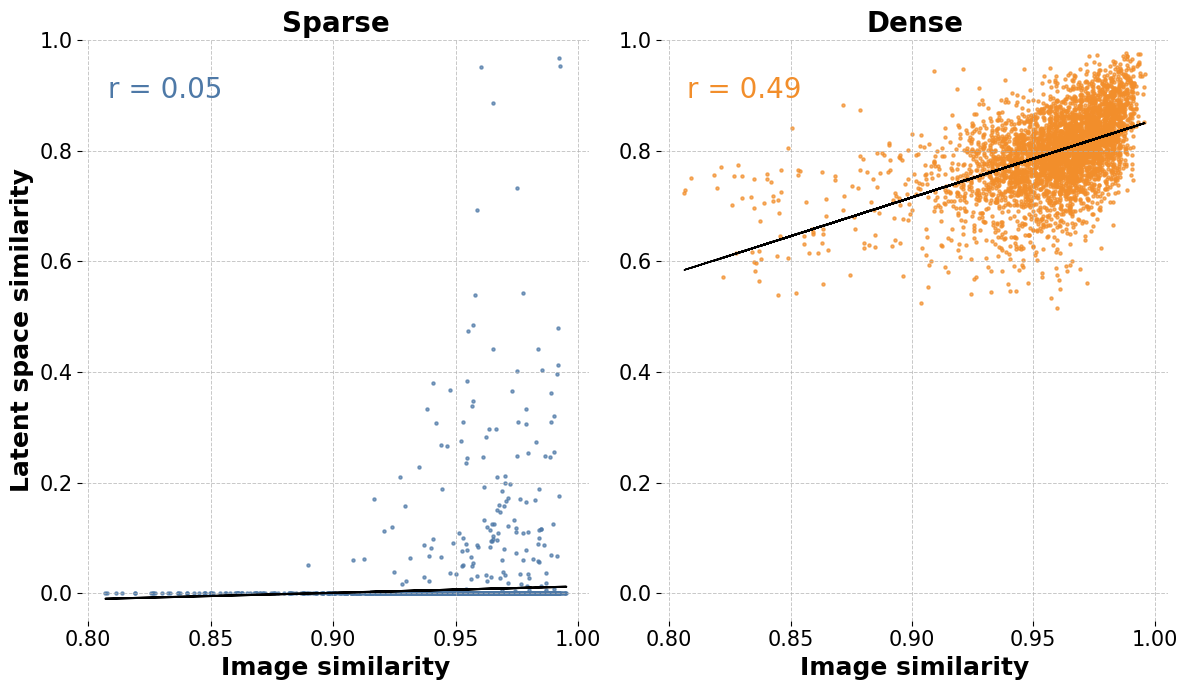

In [135]:
# Pool data across tasks
def pool_data(results, model_type):
    img_sim_all = []
    emb_sim_all = []
    for task in results[model_type].keys():
        img_sim_all.extend(results[model_type][task]['img_sim'])
        emb_sim_all.extend(results[model_type][task]['emb_sim'])
    return np.array(img_sim_all), np.array(emb_sim_all)

# Pool data for Sparse and Dense models
img_sim_sparse, emb_sim_sparse = pool_data(results, 'sparse-AE')
img_sim_dense, emb_sim_dense = pool_data(results, 'AE')

# Apply square root transformation
img_sim_sparse = np.sqrt(img_sim_sparse)
emb_sim_sparse = np.sqrt(emb_sim_sparse)
img_sim_dense = np.sqrt(img_sim_dense)
emb_sim_dense = np.sqrt(emb_sim_dense)

# Custom style settings
colors = {'sparse-AE': '#4E79A7', 'AE': '#F28E2B'}
alpha_value = 0.7  # Increased transparency

fig, axs = plt.subplots(1, 2, figsize=(12, 7))

# Sparse model plot
axs[0].scatter(img_sim_sparse, emb_sim_sparse, s=5, color=colors['sparse-AE'], alpha=alpha_value)
slope, intercept = np.polyfit(img_sim_sparse, emb_sim_sparse, 1)
axs[0].plot(img_sim_sparse, slope * img_sim_sparse + intercept, color='black', linewidth=1.5)
r_sparse, _ = pearsonr(img_sim_sparse, emb_sim_sparse)
axs[0].text(0.05, 0.9, f'r = {r_sparse:.2f}', transform=axs[0].transAxes, fontsize=20, color=colors['sparse-AE'])
axs[0].set_title('Sparse', fontsize=20, fontweight='bold')
axs[0].set_xlabel('Image similarity', fontsize=18, fontweight='bold')
axs[0].set_ylabel('Latent space similarity', fontsize=18, fontweight='bold')
axs[0].set_ylim(-0.05,1)

# Dense model plot
axs[1].scatter(img_sim_dense, emb_sim_dense, s=5, color=colors['AE'], alpha=alpha_value)
slope, intercept = np.polyfit(img_sim_dense, emb_sim_dense, 1)
axs[1].plot(img_sim_dense, slope * img_sim_dense + intercept, color='black', linewidth=1)
r_dense, _ = pearsonr(img_sim_dense, emb_sim_dense)
axs[1].text(0.05, 0.9, f'r = {r_dense:.2f}', transform=axs[1].transAxes, fontsize=20, color=colors['AE'])
axs[1].set_title('Dense', fontsize=20, fontweight='bold')
axs[1].set_xlabel('Image similarity', fontsize=18, fontweight='bold')
axs[1].set_ylim(-0.05,1)

for ax in axs:
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Despine for a cleaner look
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()

plt.savefig('plots/fig3/B_InOutSim.svg', dpi=600)

plt.show()

## Pairwise correlation and weight similarity